# Pie Chart on Map

Let's draw pie chart on map.

Take as an example the results of the Montenegrin independence referendum in 2006.
The dataset was downloaded from Wikipedia article
["2006 Montenegrin independence referendum"](https://en.wikipedia.org/wiki/2006_Montenegrin_independence_referendum).


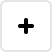
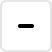
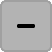
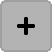
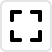
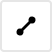
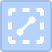
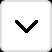
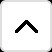
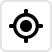

In [1]:
from lets_plot import *
from lets_plot.mapping import *

LetsPlot.setup_html() 

In [2]:
import pandas as pd

referendum_df = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/data/montenegrin_referendum_2006.csv")
referendum_df.head()

Municipality    Yes   Yes%     No    No%  Registered  Voted  Voted%
0   Andrijevica   1084  27.60   2824  71.89        4369   3928   89.91
1           Bar  16640  63.07   9496  35.99       32255  26382   81.79
2        Berane  11268  46.85  12618  52.46       28342  24051   84.86
3  Bijelo Polje  19405  55.36  15437  44.04       40110  35051   87.39
4         Budva   5908  52.75   5180  46.25       12797  11200   87.52

Let's find geographical boundaries of these states using `Lets-Plot` geocoding module. And draw the percentage of those who voted "for" on the map by regions.

In [3]:
from lets_plot.geo_data import *

country = 'Montenegro'
municipalities = geocode_states(names=referendum_df['Municipality']).scope(country)

boundaries = municipalities.get_boundaries(resolution=15)


The geodata is provided by © OpenStreetMap contributors and is made available here under the Open Database License (ODbL).


/Users/olarionova/miniconda3/lib/python3.7/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/olarionova/miniconda3/lib/python3.7/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  aout[:] = out


In [4]:
boundaries = pd.merge(boundaries, referendum_df[['Municipality','Yes%']], left_on='state', right_on='Municipality')
boundaries.head()

state            found name  \
0   Andrijevica   Opština Andrijevica   
1           Bar           Opština Bar   
2        Berane        Opština Berane   
3  Bijelo Polje  Opština Bijelo Polje   
4         Budva         Opština Budva   

                                            geometry  Municipality   Yes%  
0  MULTIPOLYGON (((19.61901 42.80456, 19.63347 42...   Andrijevica  27.60  
1  MULTIPOLYGON (((18.98948 42.16385, 18.98910 42...           Bar  63.07  
2  MULTIPOLYGON (((19.61729 42.88021, 19.62012 42...        Berane  46.85  
3  MULTIPOLYGON (((19.41061 43.07992, 19.41992 43...  Bijelo Polje  55.36  
4  MULTIPOLYGON (((18.80014 42.28039, 18.79997 42...         Budva  52.75

In [5]:
blank_theme = theme(line=element_blank(), axis=element_blank())

In [6]:
plot_title = ggtitle("Results of the Montenegrin independence referendum, 2006")

fill_colors = ['#a50026', '#d73027', '#66bd63', '#4daf4a','#006837']
    
map_layer = geom_map(aes(fill="Yes%"), 
                     data=boundaries,
                     tooltips=layer_tooltips()
                                 .title('@state')
                                 .line('\'Yes\' votes|@{Yes%}')
                                 .format('Yes%', '{} %')) + \
            scale_fill_gradientn(fill_colors)

ggplot() + map_layer + plot_title + blank_theme + ggsize(800, 700) 

Let's prepare the data for visualization and add more information.
The table will contain the following columns:
- 'Municipality' - the name of the municipality
- 'Registered' - registered voters
- 'Vote' - choice:
    - "Yes" - for the independence option
    - "No" - against independence
    - "Blank" - invalid or blank votes
- 'Number' - number of 'Vote'

In [7]:
mref_df = referendum_df

# Blank or invalid votes:
mref_df["Blank"] = mref_df["Voted"] - mref_df["Yes"] - mref_df["No"]

mref_df = mref_df[["Municipality", "Registered", "No", "Yes", "Blank"]]

id_vars = ["Municipality", "Registered"]
mref_df = pd.melt(frame=mref_df, id_vars=id_vars, var_name="Vote", value_name="Number")
mref_df

Municipality  Registered   Vote  Number
0    Andrijevica        4369     No    2824
1            Bar       32255     No    9496
2         Berane       28342     No   12618
3   Bijelo Polje       40110     No   15437
4          Budva       12797     No    5180
..           ...         ...    ...     ...
58        Rožaje       19646  Blank      90
59        Šavnik        2306  Blank      20
60         Tivat       10776  Blank      91
61        Ulcinj       17117  Blank     137
62       Žabljak        3407  Blank      24

[63 rows x 4 columns]

In [8]:
mref_df.loc[mref_df['Municipality'] == 'Bar']

Municipality  Registered   Vote  Number
1           Bar       32255     No    9496
22          Bar       32255    Yes   16640
43          Bar       32255  Blank     246

Display the voting results as pie charts. Place them in the center of the corresponding municipalities by connecting `data` and `map` with the parameter `map_join`.

In [9]:
ggplot() + \
    map_layer  + \
    geom_pie(aes(color='Vote', slice='Number'), 
             data=mref_df, stat='identity', 
             map=municipalities, map_join=['Municipality','state'],
             fill_by='color', size=5, stroke=1.5) + \
    scale_color_manual(values=[ "#e41a1c","#4daf4a", "#999999"]) + \
    plot_title + \
    blank_theme + \
    ggsize(800, 700)

In the 'count2d' statistical transformation, we will use the calculated variables: the percentage of votes ('..prop..') and the total number of voters in the municipality ('..sum..'). We will show the details in the tooltips. And let's make the pie area corresponds to the number of voters.

In [10]:
pie_layer = geom_pie(aes('Municipality', color='Vote', weight='Number', size='..sum..', group='Municipality'),
                     data=mref_df,
                     map=municipalities, map_join=['Municipality','state'],
                     fill_by='color', hole=0.2, stroke=1.5,
                     tooltips=layer_tooltips()
                              .title('@Municipality')
                              .line('Vote|@Vote')
                              .line('Number|@{..count..}')
                              .line('Percent|@{..prop..}')
                              .line('Total voted|@{..sum..}')
                              .line('Registered|@Registered')
                              .format('..prop..', '.2%')
                              .format('Registered', ',d')) + \
            scale_color_manual(values=['#e41a1c','#4daf4a', '#999999']) + \
            scale_size(name='Total voted', range=[3, 8])

ggplot() + \
    map_layer + \
    pie_layer + \
    plot_title + \
    blank_theme + \
    plot_title + \
    ggsize(800, 700)

Add livemap.

In [11]:
ggplot() + \
    geom_livemap() + \
    map_layer + \
    pie_layer + \
    plot_title + \
    theme(legend_position='none')